In [1]:
import numpy as np
import pandas as pd
import random
from os.path import join
import os
import pickle
from glob import glob
import json
import sys
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

In [13]:
DATA_DIR = '../data/'

with open(DATA_DIR + 'quantized_colors_and_names.pkl', 'rb') as infile:
    colors_dict = pickle.load(infile) 

COLOR_MAP = {k:tuple(v) for k,v in zip(colors_dict['names'], colors_dict['RGB'])}


df_scores_vectors = glob(DATA_DIR + 'scores_modifications*')
df_scores = pd.DataFrame()
for df_score in df_scores_vectors:
    df_score_l = pd.read_csv(df_score)
    df_scores = pd.concat([df_scores, df_score_l], axis=0)

df_scores = df_scores.sort_values('Final Score', ascending=False).reset_index()
df_scores['Method General'] = df_scores['Method'].str.split('_').apply(lambda x: x[0].replace('False', '').replace('True', ''))
separation_vectors = glob(DATA_DIR + '*_separation_vector*.csv')
df_sep_vecs = pd.DataFrame()
for df_sep_vec in separation_vectors:
    if 'modifications' not in df_sep_vec:
        df_sep_vec_l = pd.read_csv(df_sep_vec)
        df_sep_vecs = pd.concat([df_sep_vecs, df_sep_vec_l], axis=0)


df_scores = df_scores.merge(df_sep_vecs, left_on=['Feature','Variable','Method'], right_on=['Feature','Variable','Method'], how='left')
print(df_scores.columns)
print(df_scores[df_scores['Separation Vector'].isna()].shape, df_scores.shape)

df_scores = df_scores[df_scores['Separation Vector'].notnull()]

df_scores['Separation Vector'] = [np.array([float(x.strip('[] ')) for x in row['Separation Vector'].replace('\n', ' ').split(' ') if x.strip('[] ') != '']) for i, row in df_scores.iterrows()]
# print(df_scores[['Feature', 'Variable', 'Method', 'Final Score', 'Method General']].groupby(['Method General', 'Feature']).first().head(220), df_scores.shape)
df_scores = df_scores.sort_values('Final Score', ascending=False)
print(df_scores[['Feature', 'Variable', 'Method', 'Final Score', 'Method General']].groupby(['Method General', 'Feature']).first().groupby(['Method General']).mean(), df_scores.shape, df_scores[['Feature', 'Variable', 'Method', 'Final Score', 'Method General']].groupby(['Method General', 'Feature']).first().groupby(['Method General']).std(), df_scores.shape)


Index(['index', 'Method', 'Variable', 'Feature', 'Broad', 'Optimal lambda',
       'Total Score', 'Score lambda 1', 'Score lambda 2', 'Score lambda 3',
       'Score lambda 4', 'Score lambda 5', 'Score lambda 6', 'Score lambda 7',
       'Score lambda 8', 'Score lambda 9', 'Score lambda 10',
       'Score lambda 11', 'Score lambda 12', 'Score lambda 13',
       'Score lambda 14', 'Score lambda 15', 'Score lambda 16',
       'Score lambda 17', 'Score lambda 18', 'Score lambda 19',
       'Score lambda 20', 'Final Score', 'Score lambda 21', 'Score lambda 22',
       'Score lambda 23', 'Score lambda 24', 'Score lambda 25',
       'Method General', 'Space', 'Subfolder', 'Classes', 'Separation Vector',
       'Performance'],
      dtype='object')
(144, 39) (252, 39)
                Final Score
Method General             
InterfaceGAN       0.860944
ShapleyVec         0.888222
StyleSpace         0.867278 (108, 39)                 Final Score
Method General             
InterfaceGAN       0.0

/var/folders/s_/h4qqxs0s7mg2fw0j2hmf3jgh0000gn/T/ipykernel_38590/3188610064.py:34: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/var/folders/s_/h4qqxs0s7mg2fw0j2hmf3jgh0000gn/T/ipykernel_38590/3188610064.py:34: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [25]:
# df_scores_inter = df_scores[df_scores['Method'] == 'InterfaceGAN_LR_1_8_Color_True']
# df_scores_sv = df_scores[df_scores['Method'] == 'ShapleyVec_True_0.5_8_Color_LR']
# df_scores_ss = df_scores[df_scores['Method'] == 'StyleSpaceTrue_20_8_Color_False']

# df_scores_b = pd.concat([df_scores_inter, df_scores_sv, df_scores_ss], axis=0)

# df_scores_b.head()

In [3]:
df_scores_b = df_scores.groupby(['Method General',  'Feature', 'Broad']).first().reset_index()

In [4]:
broad = df_scores_b[df_scores_b['Broad'] == 1]
print(broad[['Feature', 'Variable', 'Method', 'Final Score', 'Method General']].groupby(['Method General', 'Feature']).first().groupby(['Method General']).mean(), broad.shape, broad[['Feature', 'Variable', 'Method', 'Final Score', 'Method General']].groupby(['Method General', 'Feature']).first().groupby(['Method General']).std(), df_scores.shape)
# broad = df_scores_sv[df_scores_sv['Broad'] == 1]
print(broad[['Feature', 'Variable', 'Method', 'Final Score', 'Method General']].groupby(['Feature']).mean(), broad.shape, df_scores[['Feature', 'Variable', 'Method', 'Final Score', 'Method General']].groupby(['Feature']).std(), df_scores.shape)

                Final Score
Method General             
InterfaceGAN       0.860944
ShapleyVec         0.888222
StyleSpace         0.867278 (54, 39)                 Final Score
Method General             
InterfaceGAN       0.080125
ShapleyVec         0.087806
StyleSpace         0.117670 (108, 39)
                       Final Score
Feature                           
ALPHA BLUE                0.723000
AMERICAN ROAST            0.923000
ANTIQUITY                 0.942000
AWARD BLUE                0.595000
CHAI TEA                  0.928667
CRUSADE KING              0.930000
FALU RED                  0.902667
FIREBIRD TAIL LIGHTS      0.914333
FUJI SNOW                 0.894667
NECRON COMPOUND           0.823333
NEPAL                     0.808667
ORANGE ESSENTIAL          0.859000
PITMASTON PEAR YELLOW     0.911000
RIVIERA BEACH             0.932333
SEED PEARL                0.908667
SUPERIOR BRONZE           0.938000
VENOM WYRM                0.826667
WOODEN CABIN              0.937667 (

/var/folders/s_/h4qqxs0s7mg2fw0j2hmf3jgh0000gn/T/ipykernel_38590/3570010350.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(broad[['Feature', 'Variable', 'Method', 'Final Score', 'Method General']].groupby(['Method General', 'Feature']).first().groupby(['Method General']).mean(), broad.shape, broad[['Feature', 'Variable', 'Method', 'Final Score', 'Method General']].groupby(['Method General', 'Feature']).first().groupby(['Method General']).std(), df_scores.shape)
/var/folders/s_/h4qqxs0s7mg2fw0j2hmf3jgh0000gn/T/ipykernel_38590/3570010350.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(broa

In [5]:
not_broad = df_scores_b[df_scores_b['Broad'] == 0]
print(not_broad[['Feature', 'Variable', 'Method', 'Final Score', 'Method General']].groupby(['Method General', 'Feature']).first().groupby(['Method General']).mean(), not_broad.shape, not_broad[['Feature', 'Variable', 'Method', 'Final Score', 'Method General']].groupby(['Method General', 'Feature']).first().groupby(['Method General']).std(), df_scores.shape)
print('ShapleyVec')
not_broad_sv = not_broad[not_broad['Method General'] == 'ShapleyVec']
print(not_broad_sv[['Feature', 'Final Score', 'Optimal lambda']].groupby(['Feature']).mean(), not_broad_sv.shape)

print('InterfaceGAN')
not_broad_in = not_broad[not_broad['Method General'] == 'InterfaceGAN']
print(not_broad_in[['Feature', 'Final Score', 'Optimal lambda']].groupby(['Feature']).mean(), not_broad_in.shape)

print('StyleSpace')
not_broad_ss = not_broad[not_broad['Method General'] == 'StyleSpace']
print(not_broad_ss[['Feature', 'Final Score', 'Optimal lambda']].groupby(['Feature']).mean(), not_broad_ss.shape)


                Final Score
Method General             
InterfaceGAN       0.235556
ShapleyVec         0.238889
StyleSpace         0.188889 (54, 39)                 Final Score
Method General             
InterfaceGAN       0.140680
ShapleyVec         0.145921
StyleSpace         0.176532 (108, 39)
ShapleyVec
                       Final Score  Optimal lambda
Feature                                           
ALPHA BLUE                    0.10             6.0
AMERICAN ROAST                0.20             7.0
ANTIQUITY                     0.22            20.0
AWARD BLUE                    0.02             6.0
CHAI TEA                      0.08             6.0
CRUSADE KING                  0.22            20.0
FALU RED                      0.18             4.0
FIREBIRD TAIL LIGHTS          0.26             5.0
FUJI SNOW                     0.48             9.0
NECRON COMPOUND               0.38            20.0
NEPAL                         0.56             8.0
ORANGE ESSENTIAL           

/var/folders/s_/h4qqxs0s7mg2fw0j2hmf3jgh0000gn/T/ipykernel_38590/2617332680.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(not_broad[['Feature', 'Variable', 'Method', 'Final Score', 'Method General']].groupby(['Method General', 'Feature']).first().groupby(['Method General']).mean(), not_broad.shape, not_broad[['Feature', 'Variable', 'Method', 'Final Score', 'Method General']].groupby(['Method General', 'Feature']).first().groupby(['Method General']).std(), df_scores.shape)
/var/folders/s_/h4qqxs0s7mg2fw0j2hmf3jgh0000gn/T/ipykernel_38590/2617332680.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


<img src="../data/Linear_RGB_color_wheel.png" width="300" height="300" style="align-text:center">

Obtaining the general similarities between vectors to see which colors are represented to be most alike and which not

In [16]:
import math

def cosine_similarity_between_angles(angle1, angle2):
    # Convert angles from degrees to radians
    angle1_rad = math.radians(angle1)
    angle2_rad = math.radians(angle2)
    
    # Calculate the difference in radians
    angle_diff = angle1_rad - angle2_rad
    
    # Calculate cosine similarity, which is just the cosine of the difference
    cosine_similarity = math.cos(angle_diff)
    
    return cosine_similarity

In [10]:
hues = {'Red':352.5, 'Brown': 17.5,'Yellow': 52.5, 'Green':110, 'Cyan':175, 'Blue':230, 'Magenta':302.5,}

hue_similarities = [0]*len(hues.items())
for i, hue in enumerate(hues.keys()):
    hue_similarities[i] = [0]*len(hues.items())
    for j, hue2 in enumerate(hues.keys()):
        hue_similarities[i][j] = cosine_similarity_between_angles(hues[hue], hues[hue2])
        
hue_similarities

[[1.0,
  0.90630778703665,
  0.5,
  -0.46174861323503436,
  -0.9990482215818578,
  -0.5372996083468239,
  0.6427876096865395],
 [0.90630778703665,
  1.0,
  0.8191520442889917,
  -0.04361938736533589,
  -0.9238795325112867,
  -0.8433914458128858,
  0.2588190451025212],
 [0.5,
  0.8191520442889917,
  1.0,
  0.5372996083468239,
  -0.5372996083468239,
  -0.9990482215818578,
  -0.3420201433256685],
 [-0.46174861323503436,
  -0.04361938736533589,
  0.5372996083468239,
  1.0,
  0.42261826174069944,
  -0.4999999999999998,
  -0.9762960071199334],
 [-0.9990482215818578,
  -0.9238795325112867,
  -0.5372996083468239,
  0.42261826174069944,
  1.0,
  0.5735764363510464,
  -0.6087614290087207],
 [-0.5372996083468239,
  -0.8433914458128858,
  -0.9990482215818578,
  -0.4999999999999998,
  0.5735764363510464,
  1.0,
  0.30070579950427284],
 [0.6427876096865395,
  0.2588190451025212,
  -0.3420201433256685,
  -0.9762960071199334,
  -0.6087614290087207,
  0.30070579950427284,
  1.0]]

In [17]:
def make_heatmap(confusion_matrix, method='hue similarity', colors=['Magenta', 'Red', 'Yellow', 'Green', 'Cyan', 'Blue', 'Purple',],
                 color_names=['magenta', 'red', 'yellow', 'green', 'cyan', 'blue', 'purple',]):
    sns.set(font_scale=0.5)
    plt.figure(figsize=(20, 12))
    g = sns.heatmap(np.array(confusion_matrix), annot=True, cmap='viridis',
                    yticklabels=colors, 
                    xticklabels=colors)
    plt.title(f"Confusion Matrix ({method})")
    for xtick, color in zip(g.get_xticklabels(), color_names):
            xtick.set_color(color)
    for ytick, color in zip(g.get_yticklabels(), color_names):
            ytick.set_color(color)
            
    #plt.xlabel("Hue Color")
    #plt.ylabel("Hue Color")
    plt.tight_layout()
    os.makedirs(join('figures',  'confusion_matrices'), exist_ok=True)
    plt.savefig(join('figures', 'confusion_matrices', f'{method}_features.png'))
    plt.show() 
    

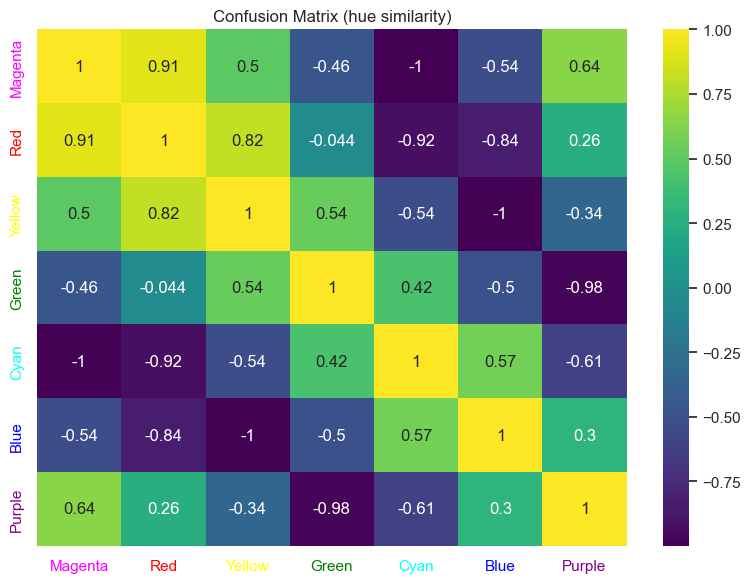

In [12]:
make_heatmap(hue_similarities, method='hue similarity')

In [9]:
df_scores = df_scores.groupby(['Method General', 'Feature']).first()
df_scores = df_scores.reset_index()
similarities = {}
colors = df_scores['Feature'].unique()
for method, group in df_scores.groupby('Method General'):
    similarities[method] = [0]*len(colors)
    print('Assessing similarity among vectors computed with:', method)
    for i, color1 in enumerate(colors):
        similarities[method][i] = [0]*len(colors)
        for j, color2 in enumerate(colors):
            
            similarity = cosine_similarity(list(group.loc[group['Feature']==color1, 'Separation Vector'])[0].reshape(1, -1),
                                                list(group.loc[group['Feature']==color2, 'Separation Vector'])[0].reshape(1, -1)
                                                )
            similarities[method][i][j] = similarity[0][0]
            
            # if color1 != color2:
            #     if len(list(group.loc[group['Feature']==color1, 'Separation Vector (np)'])
            #            ) > 0 and len(list(group.loc[group['Feature']==color2, 'Separation Vector (np)'])) > 0:
            print('Similarity between', color1, 'and', color2, 'is', np.round(similarity[0][0],3))

Assessing similarity among vectors computed with: InterfaceGAN
Similarity between ALPHA BLUE and ALPHA BLUE is 1.0
Similarity between ALPHA BLUE and AMERICAN ROAST is -0.243
Similarity between ALPHA BLUE and ANTIQUITY is -0.159
Similarity between ALPHA BLUE and AWARD BLUE is 0.14
Similarity between ALPHA BLUE and CHAI TEA is -0.151
Similarity between ALPHA BLUE and CRUSADE KING is -0.138
Similarity between ALPHA BLUE and FALU RED is -0.242
Similarity between ALPHA BLUE and FIREBIRD TAIL LIGHTS is -0.22
Similarity between ALPHA BLUE and FUJI SNOW is 0.027
Similarity between ALPHA BLUE and NECRON COMPOUND is 0.144
Similarity between ALPHA BLUE and NEPAL is 0.235
Similarity between ALPHA BLUE and ORANGE ESSENTIAL is 0.054
Similarity between ALPHA BLUE and PITMASTON PEAR YELLOW is -0.11
Similarity between ALPHA BLUE and RIVIERA BEACH is -0.098
Similarity between ALPHA BLUE and SEED PEARL is -0.022
Similarity between ALPHA BLUE and SUPERIOR BRONZE is -0.12
Similarity between ALPHA BLUE and 

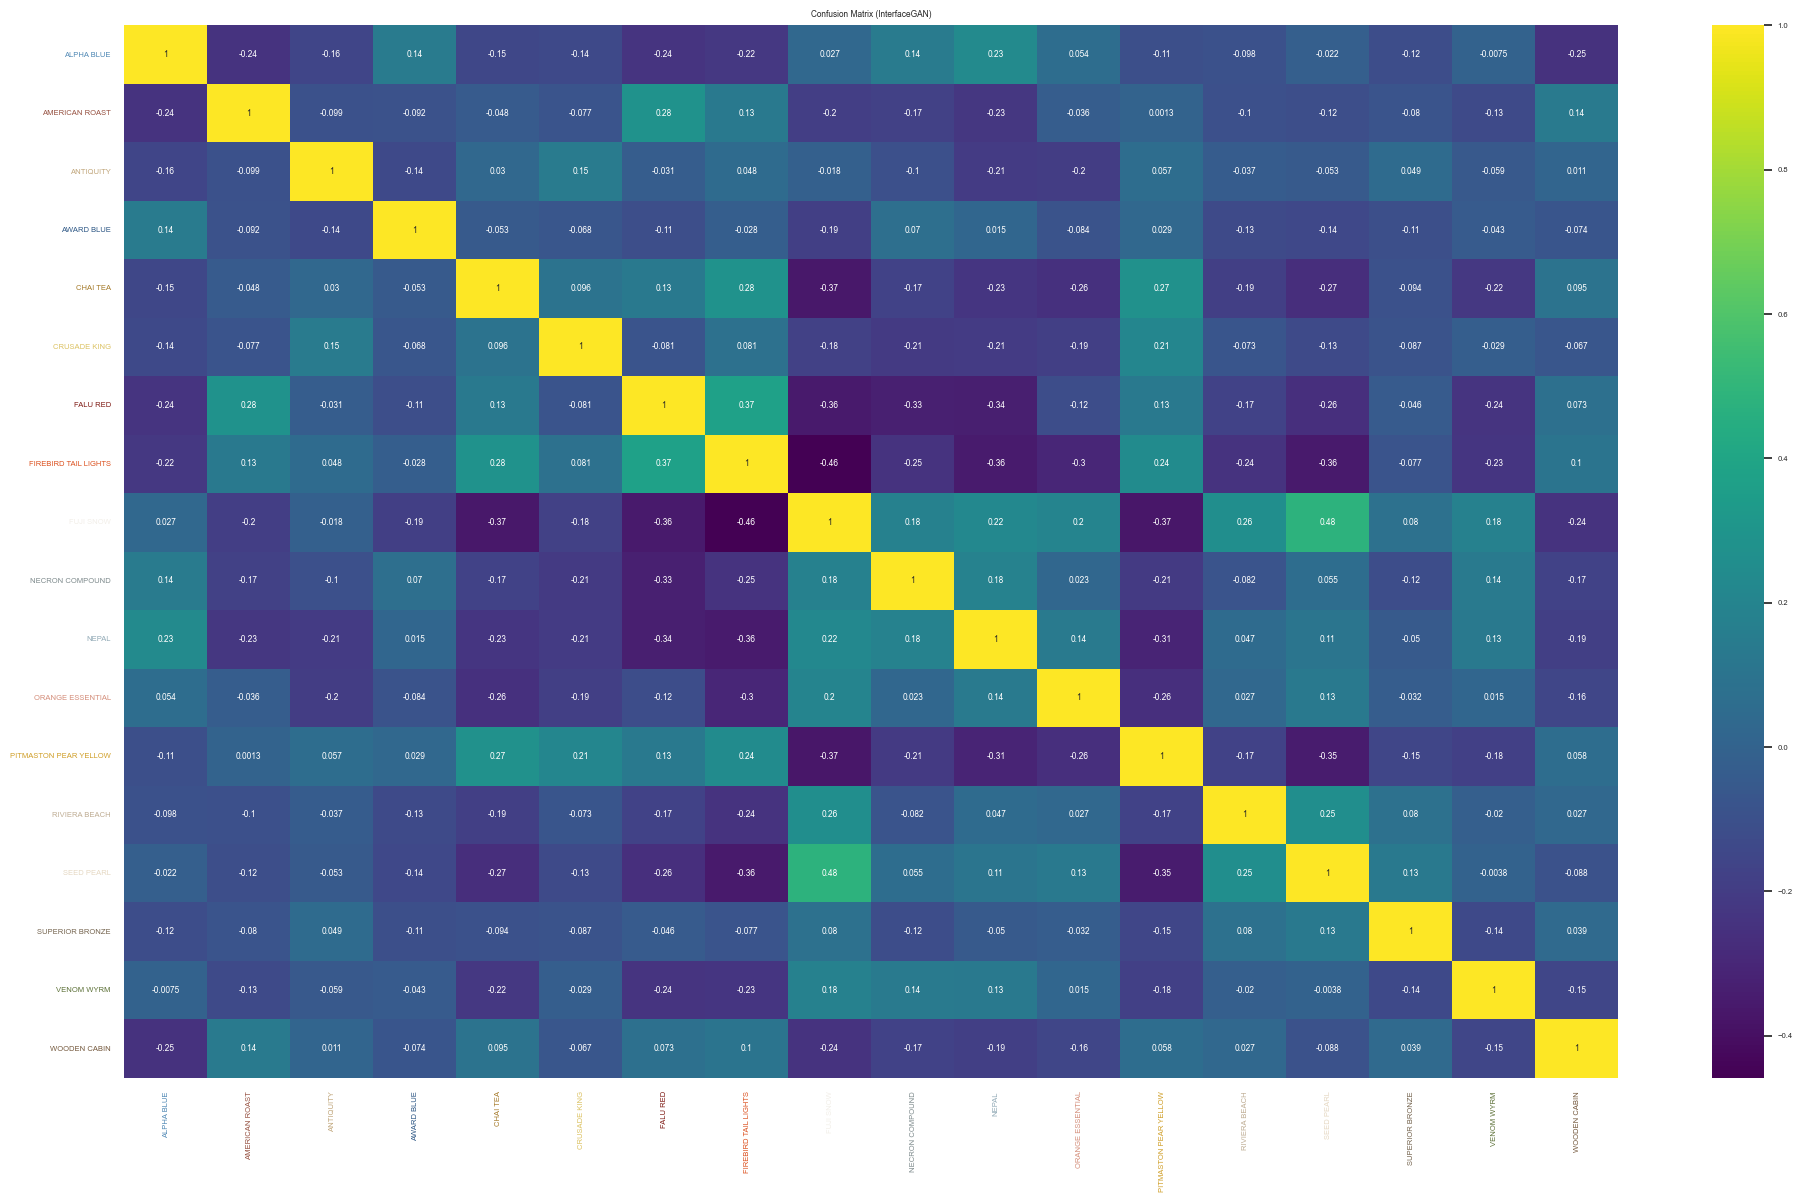

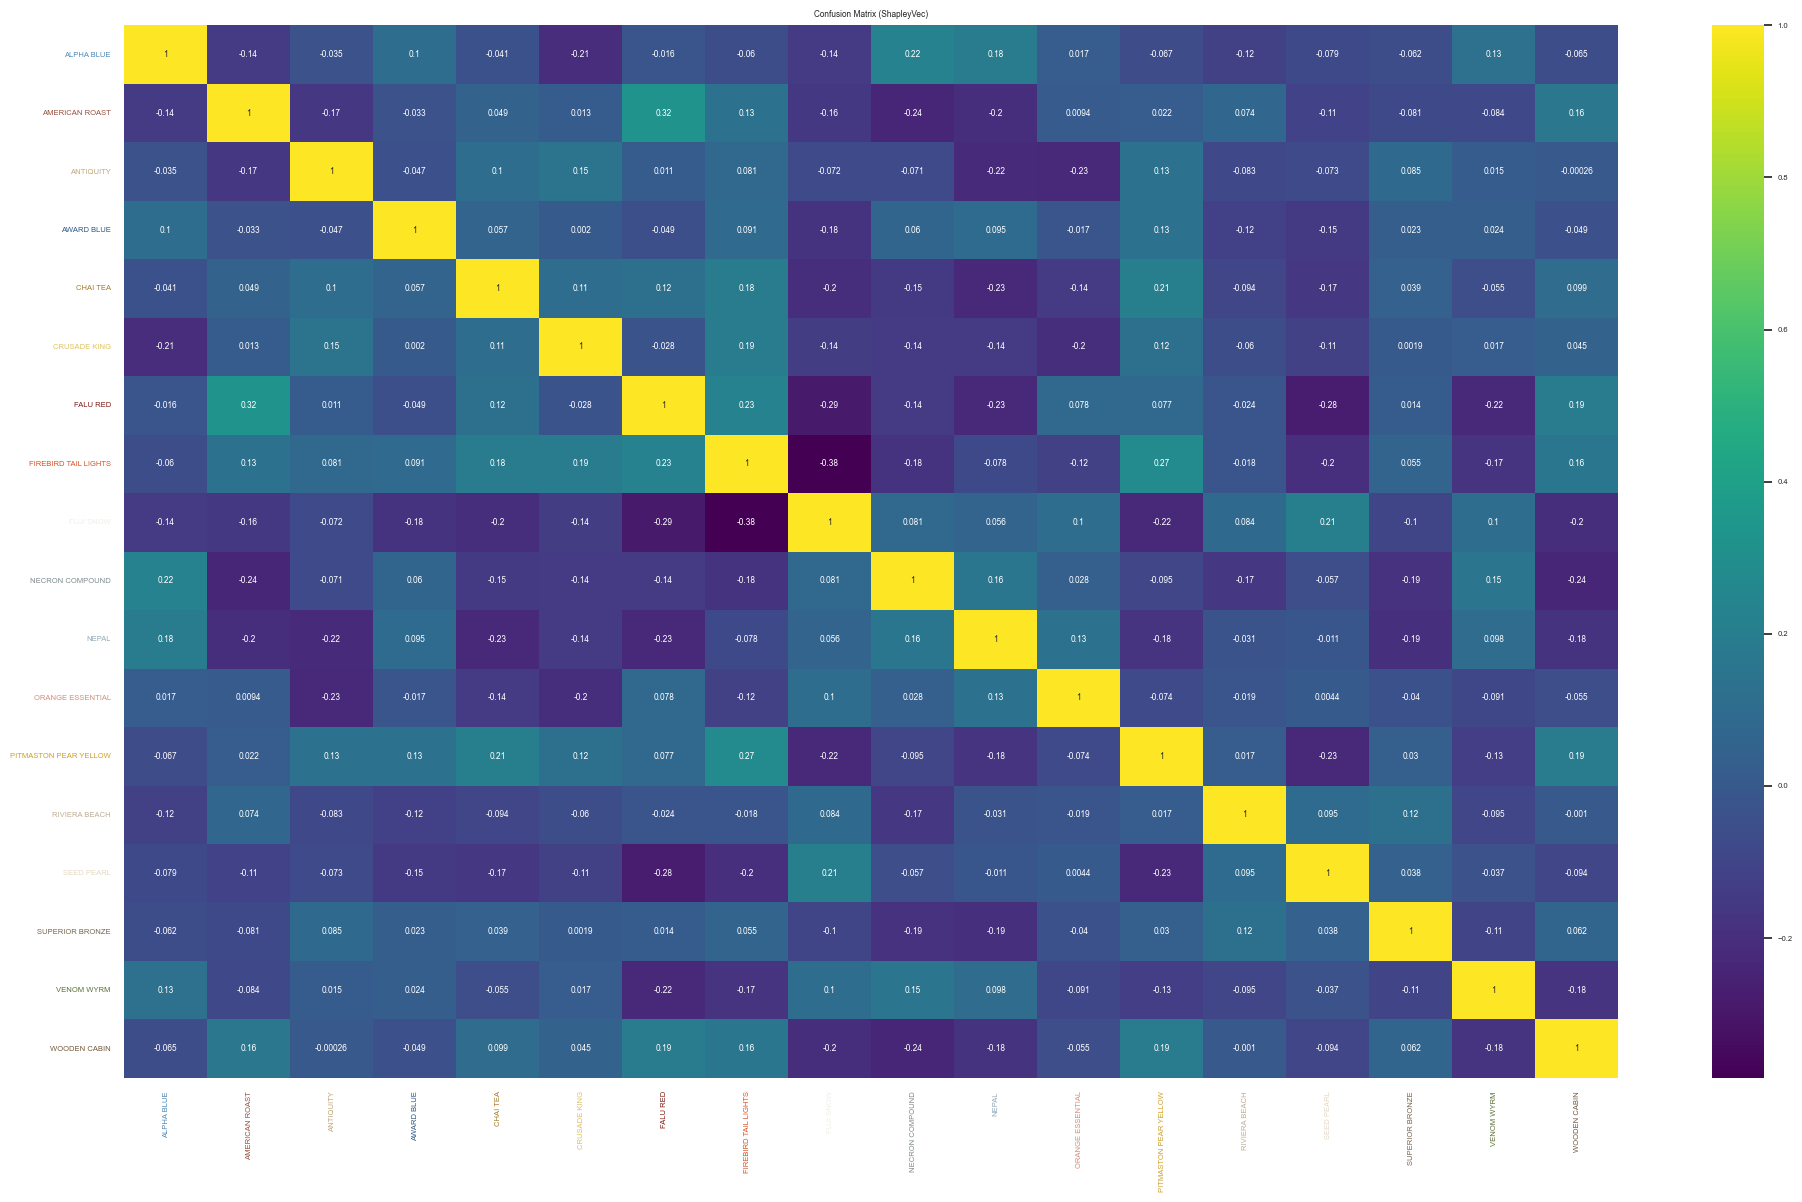

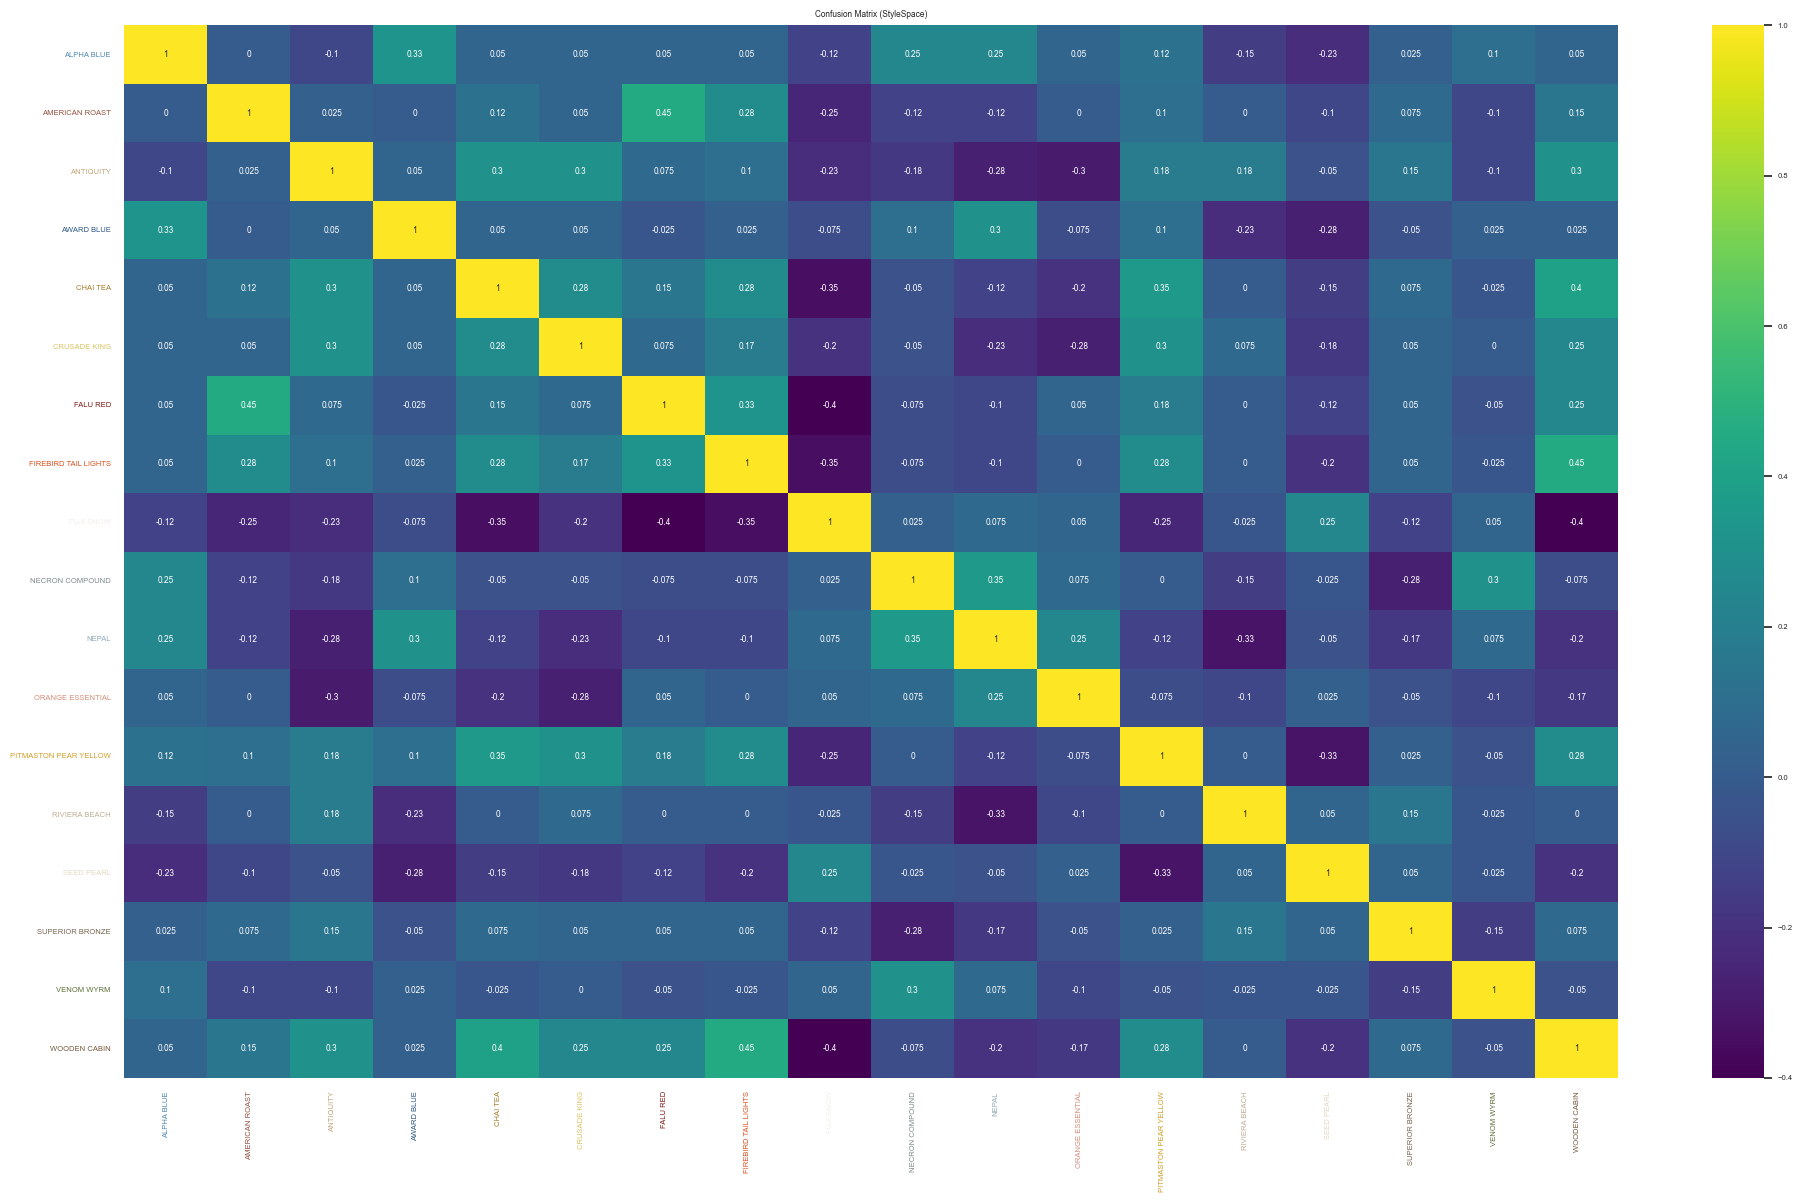

In [18]:
for k,v in similarities.items():
    make_heatmap(v, method=k, colors=colors, color_names=[COLOR_MAP[col] for col in colors])

In [23]:
import plotly.graph_objects as go
import numpy as np

colors = df_scores['Feature'].unique()

# similarities = similarities['ShapleyVec']
# Assuming 'similarities' is a dictionary with your calculated similarities
# Calculate the average similarities
# for color1 in similarities:
#     for color2 in similarities[color1]:
#         print(color1, color2)
#         similarities[color1][color2] = np.round(np.mean(similarities[color1][color2]),2)

# Prepare data for Sankey diagram
source = []
target = []
value = []
# colors_out = [col+'_out' for col in colors]
color_index = {color: i for i, color in enumerate(list(colors))}
print(color_index)
for color1 in similarities:
    for color2 in similarities[color1]:
        if color1 != color2:
            source.append(color_index[color1])
            target.append(color_index[color2])
            value.append(abs(similarities[color1][color2]))  # Use absolute values

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=list(colors)
    ),
    link=dict(
      source=source,
      target=target,
      value=value
    ))])

fig.update_layout(title_text="Average Similarities Among Colors", font_size=10)
fig.show()


{'SUPERIOR BRONZE': 0, 'RIVIERA BEACH': 1, 'ANTIQUITY': 2, 'CRUSADE KING': 3, 'WOODEN CABIN': 4, 'SEED PEARL': 5, 'FALU RED': 6, 'FUJI SNOW': 7, 'CHAI TEA': 8, 'PITMASTON PEAR YELLOW': 9, 'AMERICAN ROAST': 10, 'FIREBIRD TAIL LIGHTS': 11, 'NECRON COMPOUND': 12, 'NEPAL': 13, 'ORANGE ESSENTIAL': 14, 'VENOM WYRM': 15, 'ALPHA BLUE': 16, 'AWARD BLUE': 17}


TypeError: list indices must be integers or slices, not list

In [129]:
for c1 in similarities.keys():
    for c2 in similarities[c1].keys():
        if len(similarities[c1][c2]) > 0:
            print('Average similarity across methods', c1, c2, 'is', np.round(np.mean(similarities[c1][c2]), 3),
                  'with std', np.round(np.std(similarities[c1][c2]), 3))

AttributeError: 'list' object has no attribute 'keys'

<img src="../data/color_systems.png" width="400" height="200">

Now trying out different vector algebras to see which properties from the subtractive and additive schemes hold

In [20]:
df_scores_interface = df_scores[df_scores['Method General'] == 'InterfaceGAN']

In [21]:
print(df_scores_interface.shape)
# df_scores_interface = df_scores_interface[~df_scores_interface['Feature'].isin(['S1', 'V1', 'BW', 'Brown'])].reset_index()

df_scores_interface.head(1)

(36, 39)


,index,Method,Variable,Feature,Broad,Optimal lambda,Total Score,Score lambda 1,Score lambda 2,Score lambda 3,...,Score lambda 22,Score lambda 23,Score lambda 24,Score lambda 25,Method General,Space,Subfolder,Classes,Separation Vector,Performance
27,29,InterfaceGAN_LR_0.1_18_color_True,color,FALU RED,True,14.0,0.918,0.818,0.825,0.835,...,NaN,NaN,NaN,NaN,InterfaceGAN,w,interfaceGAN_beauty/color/,"SEED PEARL, FUJI SNOW, ORANGE ESSENTIAL, RIVIE...","[0.0120245996, -0.00577077604, 0.00687366128, ...",0.26


In [25]:
color2vector = {k:v for k,v in zip(df_scores_interface['Feature'],df_scores_interface['Separation Vector'])}

In [26]:
# Function to normalize a vector
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

# Sum and subtract pairwise and normalize
resultant_vectors = [(normalize(a*v1 + b*v2), k1 + '+' + k2 + ' a ' + str(a) + ' b ' + str(b)
                      ) for k1, v1 in color2vector.items() for k2, v2 in color2vector.items() for a in range(1,5) 
                     for b in range(1,5) if k1 != k2 and k1 not in ['S1', 'V1', 'BW', 'Brown'] and k2 not in ['S1', 'V1', 'BW', 'Brown']]


resultant_vectors += [(normalize(a*v1 - b*v2), k1 + '-' + k2 + ' a ' + str(a) + ' b ' + str(b)
                      ) for k1, v1 in color2vector.items() for k2, v2 in color2vector.items() for a in range(1,5) 
                     for b in range(1,5) if k1 != k2 and k1 not in ['S1', 'V1', 'BW', 'Brown'] and k2 not in ['S1', 'V1', 'BW', 'Brown']]

# Find the most similar vector
for rv in resultant_vectors:
    most_similar = None
    highest_similarity = -1
    for ov in color2vector.items():
        if ov[0] not in ['S1', 'V1', 'BW', 'Brown']:
            similarity = np.dot(rv[0], ov[1])
            if np.abs(similarity) > highest_similarity:
                if ov[0] not in rv[1]:
                    most_similar = ov[0]
                    highest_similarity = similarity
    if highest_similarity > 0.2:
        print("Most Similar Vector:", most_similar, 'to', rv[1], 'with similarity', highest_similarity)


In [27]:
additive_colors = [(normalize(v1 + v2), k1 + '+' + k2
                      ) for k1, v1 in color2vector.items() for k2, v2 in color2vector.items() 
                   if k1 != k2 and k1 in ['Red', 'Green', 'Blue'] and k2 in ['Red', 'Green', 'Blue']]


subtractive_colors = [(normalize(v1 - v2), k1 + '-' + k2 
                      ) for k1, v1 in color2vector.items() for k2, v2 in color2vector.items() 
                      if k1 != k2 and k1 in ['Cyan', 'Magenta', 'Yellow'] and k2 in ['Cyan', 'Magenta', 'Yellow']]

# Find the most similar vector
for rv in additive_colors:
    for ov in color2vector.items():
        if ov[0] not in ['S1', 'V1', 'BW', 'Brown']:
            similarity = np.dot(rv[0], ov[1])
            if ov[0] not in rv[1]:
                print("Vector:", ov[0], 'is similar to', rv[1], 'with similarity', similarity)


In [135]:
import plotly.graph_objects as go
import numpy as np

# Assuming color2vector is your dictionary of colors to vectors
# and you've computed additive_colors and subtractive_colors as given

# Calculate similarities and prepare data for Sankey diagram
source = []
target = []
value = []
labels = []

# Additive colors
for rv in additive_colors:
    for ov in color2vector.items():
        if ov[0] not in ['S1', 'V1', 'BW', 'Brown']:
            similarity = np.dot(rv[0], ov[1])
            if ov[0] not in rv[1]:
                # Add to Sankey data
                if rv[1] not in labels:
                    labels.append(rv[1])
                if ov[0] not in labels:
                    labels.append(ov[0])

                source.append(labels.index(rv[1]))
                target.append(labels.index(ov[0]))
                value.append(similarity)

# Assuming subtractive_colors follows the same structure
for rv in subtractive_colors:
    for ov in color2vector.items():
        if ov[0] not in ['S1', 'V1', 'BW', 'Brown']:
            similarity = np.dot(rv[0], ov[1])
            if ov[0] not in rv[1]:
                # Add to Sankey data
                if rv[1] not in labels:
                    labels.append(rv[1])
                if ov[0] not in labels:
                    labels.append(ov[0])

                source.append(labels.index(rv[1]))
                target.append(labels.index(ov[0]))
                value.append(similarity)
    # Similar logic as above

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels
    ),
    link=dict(
      source=source,
      target=target,
      value=value
    ))])

fig.update_layout(title_text="Similarities between Additive and Subtractive Colors", font_size=10)
fig.show()


In [136]:
# Find the most similar vector
for rv in subtractive_colors:
    for ov in color2vector.items():
        if ov[0] not in ['S1', 'V1', 'BW', 'Brown']:
            similarity = np.dot(rv[0], ov[1])
            if ov[0] not in rv[1]:
                print("Vector:", ov[0], 'is similar to', rv[1], 'with similarity', similarity)


Vector: Blue is similar to Cyan-Magenta with similarity 0.12587683731204344
Vector: Green is similar to Cyan-Magenta with similarity 0.14263542796163564
Vector: Red is similar to Cyan-Magenta with similarity -0.2555212368853957
Vector: Yellow is similar to Cyan-Magenta with similarity 0.028695031451628116
Vector: Blue is similar to Cyan-Yellow with similarity 0.23007314367393233
Vector: Green is similar to Cyan-Yellow with similarity 0.06804331696217854
Vector: Magenta is similar to Cyan-Yellow with similarity 0.054292668391245386
Vector: Red is similar to Cyan-Yellow with similarity -0.12337473604229532
Vector: Blue is similar to Magenta-Cyan with similarity -0.12587683731204344
Vector: Green is similar to Magenta-Cyan with similarity -0.14263542796163564
Vector: Red is similar to Magenta-Cyan with similarity 0.2555212368853957
Vector: Yellow is similar to Magenta-Cyan with similarity -0.028695031451628116
Vector: Blue is similar to Magenta-Yellow with similarity 0.10633974947524305
V

Similarity across channels

In [25]:
df_scores_shapley = df_scores[df_scores['Method General'] == 'ShapleyVec']#[df_scores['Method'].str.contains('0.25')]
print(df_scores_shapley.shape)
df_scores_shapley.head(1)

(36, 39)


,index,Method,Variable,Feature,Broad,Optimal lambda,Total Score,Score lambda 1,Score lambda 2,Score lambda 3,...,Score lambda 22,Score lambda 23,Score lambda 24,Score lambda 25,Method General,Space,Subfolder,Classes,Separation Vector,Performance
0,61,ShapleyVec_True_0.5_18_color_LR,color,SUPERIOR BRONZE,True,20.0,0.946,0.891,0.908,0.925,...,NaN,NaN,NaN,NaN,ShapleyVec,w,ShapleyVec_beauty/color/,"SEED PEARL, FUJI SNOW, ORANGE ESSENTIAL, RIVIE...","[0.0611, 0.0, 0.0, 0.0, -0.0028, 0.0, 0.0, 0.0...",NaN


In [26]:
channels = {}
for color, vecs in zip(df_scores_shapley['Feature'], df_scores_shapley['Separation Vector (np)']):
    channels[color] = np.where(vecs != 0)
    print('Color', color, 'requires', len(channels[color][0]), 'channels to represent it')

colors = df_scores_shapley['Feature'].unique()
for color1 in colors:
    for color2 in colors:
        if color1 != color2:
            inters = np.intersect1d(channels[color1], channels[color2])
            print('Color', color1, 'and color', color2, 'intersect by', len(inters), 'channels, out of the max possible channels', 
                  min(len(channels[color2][0]), len(channels[color1][0])), inters)

KeyError: 'Separation Vector (np)'

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize


# Example data: 8 sets of numbers
sets = [set(list(chan[0])) for chan in list(channels.values())]
names = [col.lower() if col != 'BW' else 'grey' for col in list(channels.keys())]


# Calculate desired overlaps
desired_overlaps = np.zeros((len(sets), len(sets)))
for i, set1 in enumerate(sets):
    for j, set2 in enumerate(sets):
        if i != j:
            overlap = len(set1.intersection(set2)) / len(set1.union(set2))
            desired_overlaps[i, j] = overlap


# Function to minimize: difference between actual and desired overlaps
def overlap_error(positions):
    positions = positions.reshape((len(sets), 2))
    error = 0
    for i in range(len(sets)):
        for j in range(i + 1, len(sets)):
            dx, dy = positions[i] - positions[j]
            distance = np.sqrt(dx**2 + dy**2)
            actual_overlap = max(0, 1 - distance)  # Simplified overlap calculation
            error += (actual_overlap - desired_overlaps[i, j])**2
    return error

# Initial positions
initial_positions = np.random.rand(len(sets), 2).flatten()

# Minimize the error function
optimized = minimize(overlap_error, initial_positions, method='BFGS')
optimized_positions = optimized.x.reshape((len(sets), 2))

print(optimized_positions)
fig, ax = plt.subplots()
for i, s in enumerate(sets):
    ax.scatter(optimized_positions[i, 0], optimized_positions[i, 1], s=100 * len(s), alpha=0.5, color=names[i])
    ax.text(optimized_positions[i, 0], optimized_positions[i, 1], f"{names[i]}", ha='center', va='center', color='black')

plt.title("Bubble Plot of Number Sets with Overlap")
plt.show()


ValueError: zero-size array to reduction operation maximum which has no identity

In [28]:
colors = df_scores_shapley['Feature'].unique()
for color1 in colors:
    for color2 in colors:
        if color1 != color2:
            inters = np.intersect1d(channels[color1], channels[color2])
            for color3 in colors:
                if color3 != color2 and color3 != color1:
                    inters = np.intersect1d(channels[color3], inters)
                    if len(inters) > 0:
                        print('Color', color1, ', color', color2, ', color', color3, 'and color', color4, 'intersect by', len(inters), 'node(s)', inters)

KeyError: 'SUPERIOR BRONZE'

Now we do the same for stylespace

In [141]:
df_scores_stylespace = df_scores[df_scores['Method General'] == 'StyleSpace']
print(df_scores_stylespace.shape)
df_scores_stylespace.head(1)

(8, 31)


,Method General,Feature,index,Method,Variable,Broad,Optimal lambda,Total Score,Score lambda 1,Score lambda 2,...,Score lambda 14,Score lambda 15,Final Score,Space,Subfolder,Performance,Classes,Bins,Separation Vector,Separation Vector (np)
18,StyleSpace,BW,80,StyleSpaceTrue_1_8_Color_False,Color,0.0,15.0,0.178,0.054,0.081,...,0.378,0.405,0.405,w,StyleSpace/color/,NaN,"BW, Brown, Yellow, Cyan, Blue, Green, Red, Mag...","[0, 35, 70, 150, 200, 260, 345, 360]",[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [146]:
channels = {}
sign_channels = {}
for color, vecs in zip(df_scores_stylespace['Feature'], df_scores_stylespace['Separation Vector (np)']):
    channels[color] = np.where(vecs != 0)
    # print('values color', color, vecs[np.where(vecs!= 0)], np.where(vecs!= 0))
    print('Color', color, 'requires', len(channels[color][0]), 'channels to represent it')

colors = df_scores_stylespace['Feature'].unique()
for color1 in colors:
    for color2 in colors:
        if color1 != color2:
            inters = np.intersect1d(channels[color1], channels[color2])
            print('Color', color1, 'and color', color2, 'intersect by', len(inters), inters, 'channels, out of the max possible channels', 
                  min(len(channels[color2][0]), len(channels[color1][0])))

Color BW requires 1 channels to represent it
Color Blue requires 5 channels to represent it
Color Brown requires 5 channels to represent it
Color Cyan requires 20 channels to represent it
Color Green requires 20 channels to represent it
Color Magenta requires 10 channels to represent it
Color Red requires 20 channels to represent it
Color Yellow requires 20 channels to represent it
Color BW and color Blue intersect by 0 [] channels, out of the max possible channels 1
Color BW and color Brown intersect by 0 [] channels, out of the max possible channels 1
Color BW and color Cyan intersect by 0 [] channels, out of the max possible channels 1
Color BW and color Green intersect by 1 [119] channels, out of the max possible channels 1
Color BW and color Magenta intersect by 1 [119] channels, out of the max possible channels 1
Color BW and color Red intersect by 0 [] channels, out of the max possible channels 1
Color BW and color Yellow intersect by 1 [119] channels, out of the max possible ch

In [143]:
colors = df_scores_stylespace['Feature'].unique()
for color1 in colors:
    for color2 in colors:
        if color1 != color2:
            inters = np.intersect1d(channels[color1], channels[color2])
            for color3 in colors:
                if color3 != color2 and color3 != color1:
                    inters = np.intersect1d(channels[color3], inters)
                    #for color4 in colors:
                    #    if color4 != color2 and color4 != color1 and color4 != color3:
                    #        inters = np.intersect1d(channels[color4], inters)
                    if len(inters) > 0:
                        print('Color', color1, ', color', color2, ', color', color3, 'intersect by', len(inters), 'node(s)', inters)

Color Green , color Magenta , color BW intersect by 1 node(s) [119]
Color Green , color Yellow , color BW intersect by 1 node(s) [119]
Color Magenta , color Green , color BW intersect by 1 node(s) [119]
Color Magenta , color Yellow , color BW intersect by 1 node(s) [119]
Color Yellow , color Green , color BW intersect by 1 node(s) [119]
Color Yellow , color Magenta , color BW intersect by 1 node(s) [119]
